In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
filepath = "./gdrive/MyDrive/DVA-project-covid-nursing-home/"

To access files from shared folder, add the shared folder as shortcut to your google drive

see: https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

In [ ]:
import os
os.listdir(filepath+"data")

['ltc-nursing home characteristics_2020.xlsx',
 'Extra data and map examples.docx',
 'ltc-data_dictionary_NEW.xlsx',
 'team 88 project data get nursing home lat and long .ipynb',
 'nursing_home_lat_long.csv',
 'County_level_weekly_covid_data.csv',
 'COVID_19_Nursing_Home_Data_10_16_2022_with_lat_long_county_level_data.csv',
 'rural_urban_codes_2013.xls',
 'rural_urban_codes_2013.csv',
 'COVID_19_Nursing_Home_Data_10_30_2022.csv',
 'NH_ProviderInfo_Oct2022.csv',
 'County_level_weekly_covid_data.gsheet']

In [ ]:
import pandas as pd 
import numpy as np
import random as rd
rd.seed(1887)
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None

#1. Read nursing home data from 1_read_input_data

In [ ]:
df_nh_data=pd.read_csv(filepath+'model/output_data/df_nh_data.csv',dtype = {'nh_id':'str'})

1.1 data quality is much better after 2021-5-23. With vaccination become widely avaliable after late 2020 to mid 2021, the pattern of comfirmed cases could change significantly --- drop data before 2021-1-30

In [ ]:
df_nh_data['date'] =  pd.to_datetime(df_nh_data['date'])
#df_nh_data = df_nh_data[(df_nh_data['date'] >= '2021-01-30')]

1.2 keep nh with 100+ beds only

In [ ]:
nh_ids = df_nh_data.loc[df_nh_data['n_beds'] > 20, 'nh_id'].unique()
df_nh_data = df_nh_data[df_nh_data['nh_id'].isin(nh_ids)]
df_nh_data.reset_index(inplace = True,drop = True)

In [ ]:
df_nh_data.head()

,nh_id,date,data_qa_check,nh_county,nh_state,resi_week_confirm,resi_total_confirm,resi_week_death,resi_total_death,n_beds,n_occupied_beds,staff_week_confirm,staff_total_confirm,staff_week_death,staff_total_death,able_to_test,shortage_supply,n_resi,pct_vaccine_resi,n_staff,pct_vaccine_staff,pct_utd_vaccine_resi,pct_utd_vaccine_staff,num_treatment,shortage_staff,nh_nm,Address,Lat,Long,ownership,nh_rating,turnover_nursing_staff,nurse_staff_hrs,nh_health_survey_score,n_fine,amt_fine,n_penalty,acuindex2,paymcaid,paymcare,agghighcfs,pctfem,pctunder65,pctblack_mds3,pcthisp_mds3,pctwhite_mds3,county_weekly_confirmed,county_weekly_death
0,015009,2020-05-31,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,42.0,2.0,35.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,NaN,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,NaN,79.59,22.45,NaN,0.0,89.8,3606.0,46.0
1,015009,2020-06-07,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,43.0,0.0,35.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,NaN,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,NaN,79.59,22.45,NaN,0.0,89.8,4140.0,59.0
2,015009,2020-06-14,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,43.0,0.0,35.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,NaN,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,NaN,79.59,22.45,NaN,0.0,89.8,4662.0,70.0
3,015009,2020-06-21,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,45.0,0.0,35.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,NaN,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,NaN,79.59,22.45,NaN,0.0,89.8,5328.0,70.0
4,015009,2020-06-28,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,46.0,0.0,35.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,NaN,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,NaN,79.59,22.45,NaN,0.0,89.8,5692.0,74.0


In [ ]:
len(df_nh_data)

1834299

In [ ]:
len(df_nh_data[df_nh_data["data_qa_check"] == "N"])

6498

In [ ]:
len(df_nh_data['nh_id'].unique())

14565

#2. Missing value treatment

In [ ]:
df_nh_data.dtypes

nh_id                              object
date                       datetime64[ns]
data_qa_check                      object
nh_county                          object
nh_state                           object
resi_week_confirm                 float64
resi_total_confirm                float64
resi_week_death                   float64
resi_total_death                  float64
n_beds                            float64
n_occupied_beds                   float64
staff_week_confirm                float64
staff_total_confirm               float64
staff_week_death                  float64
staff_total_death                 float64
able_to_test                       object
shortage_supply                    object
n_resi                            float64
pct_vaccine_resi                  float64
n_staff                           float64
pct_vaccine_staff                 float64
pct_utd_vaccine_resi              float64
pct_utd_vaccine_staff             float64
num_treatment                     

In [ ]:
df_nh_data.isnull().sum()

nh_id                            0
date                             0
data_qa_check                    0
nh_county                        0
nh_state                         0
resi_week_confirm                0
resi_total_confirm               0
resi_week_death                  0
resi_total_death                 0
n_beds                        6064
n_occupied_beds               2811
staff_week_confirm               0
staff_total_confirm              0
staff_week_death                 0
staff_total_death                0
able_to_test               1517616
shortage_supply            1517616
n_resi                      769563
pct_vaccine_resi            769563
n_staff                     769861
pct_vaccine_staff          1820845
pct_utd_vaccine_resi        769563
pct_utd_vaccine_staff       769861
num_treatment               793545
shortage_staff              247683
nh_nm                            0
Address                          0
Lat                              0
Long                

For fixed values, forward fill them using latest value avaliable, then backward fill if still missing.

For values which are not expected to move drastically in a short period of time, forward fill only. Skipping backward fill to avoid peeking into the future.

This is would be effective for fields from nh panel data ONLY.

In [ ]:
fixed_vars = ['n_beds','ownership']
slow_move_vars = ['n_occupied_beds','n_resi','n_staff']
df_nh_data[fixed_vars] = df_nh_data[fixed_vars].fillna(df_nh_data.groupby(['nh_id'])[fixed_vars + slow_move_vars].ffill())
df_nh_data[fixed_vars] = df_nh_data[fixed_vars].fillna(df_nh_data.groupby(['nh_id'])[fixed_vars + slow_move_vars].bfill())

for other numeric values, use forward filling only. We may need to spend more time figuring out the best way to treat them

In [ ]:
other_numeric_vars = ['able_to_test','shortage_supply','pct_vaccine_resi','pct_vaccine_staff','pct_utd_vaccine_resi','pct_utd_vaccine_staff','num_treatment']
df_nh_data[other_numeric_vars] = df_nh_data[other_numeric_vars].fillna(df_nh_data.groupby(['nh_id'])[other_numeric_vars].ffill())

use mean value if still missing

In [ ]:
# fill mean values at nh, country, state, national level gradually.
fill_mean_vars = ["n_resi", "n_staff", "n_occupied_beds", "pctfem", "turnover_nursing_staff", "nurse_staff_hrs", "nh_rating", "nh_health_survey_score", "acuindex2", "paymcaid", "paymcare", "agghighcfs", "pctfem", "pctunder65", "pctblack_mds3", "pcthisp_mds3", "pctwhite_mds3"]
for col in fill_mean_vars:
  df_nh_data[col]=df_nh_data.groupby('nh_id')[col].apply(lambda x:x.fillna(x.mean()))
  df_nh_data[col]=df_nh_data.groupby('nh_county')[col].apply(lambda x:x.fillna(x.mean()))
  df_nh_data[col]=df_nh_data.groupby('nh_state')[col].apply(lambda x:x.fillna(x.mean()))
  df_nh_data[col].fillna(value=df_nh_data[col].mean(), inplace = True)


In [ ]:
# it still contains NA value by using ffill for below columsn, fill 0 since vaccine are not available at that time 
fill_zero_vars = ["pct_vaccine_resi", "pct_vaccine_staff", "pct_utd_vaccine_resi", "pct_utd_vaccine_staff","num_treatment"]
df_nh_data[fill_zero_vars] = df_nh_data[fill_zero_vars].fillna(0)

No need to worry about missings in categorical variables since we would use One-Hot encoding on them 

In [ ]:
df_nh_data.isnull().sum()

nh_id                            0
date                             0
data_qa_check                    0
nh_county                        0
nh_state                         0
resi_week_confirm                0
resi_total_confirm               0
resi_week_death                  0
resi_total_death                 0
n_beds                           0
n_occupied_beds                  0
staff_week_confirm               0
staff_total_confirm              0
staff_week_death                 0
staff_total_death                0
able_to_test               1516239
shortage_supply            1516239
n_resi                           0
pct_vaccine_resi                 0
n_staff                          0
pct_vaccine_staff                0
pct_utd_vaccine_resi             0
pct_utd_vaccine_staff            0
num_treatment                    0
shortage_staff              247683
nh_nm                            0
Address                          0
Lat                              0
Long                

In [ ]:
df_nh_data.head()

,nh_id,date,data_qa_check,nh_county,nh_state,resi_week_confirm,resi_total_confirm,resi_week_death,resi_total_death,n_beds,n_occupied_beds,staff_week_confirm,staff_total_confirm,staff_week_death,staff_total_death,able_to_test,shortage_supply,n_resi,pct_vaccine_resi,n_staff,pct_vaccine_staff,pct_utd_vaccine_resi,pct_utd_vaccine_staff,num_treatment,shortage_staff,nh_nm,Address,Lat,Long,ownership,nh_rating,turnover_nursing_staff,nurse_staff_hrs,nh_health_survey_score,n_fine,amt_fine,n_penalty,acuindex2,paymcaid,paymcare,agghighcfs,pctfem,pctunder65,pctblack_mds3,pcthisp_mds3,pctwhite_mds3,county_weekly_confirmed,county_weekly_death
0,015009,2020-05-31,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,42.0,2.0,35.0,0.0,0.0,NaN,NaN,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,3606.0,46.0
1,015009,2020-06-07,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,43.0,0.0,35.0,0.0,0.0,NaN,NaN,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,4140.0,59.0
2,015009,2020-06-14,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,43.0,0.0,35.0,0.0,0.0,NaN,NaN,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,4662.0,70.0
3,015009,2020-06-21,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,45.0,0.0,35.0,0.0,0.0,NaN,NaN,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,5328.0,70.0
4,015009,2020-06-28,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,46.0,0.0,35.0,0.0,0.0,NaN,NaN,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,False,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,For profit - Corporation,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,5692.0,74.0


#3. One-hot encoding categorical variables

In [ ]:
#from sklearn.preprocessing import OneHotEncoder

pre-processing cat vars

In [ ]:
#df_nh_data.loc[df_nh_data["able_to_test"] == "0",'able_to_test'] = "N"
df_nh_data.loc[df_nh_data["ownership"].str.contains("Government",regex=False,na=False), "ownership"] = "Government"
df_nh_data.loc[df_nh_data["ownership"].str.contains("For profit",regex=False,na=False), "ownership"] = "For Profit"
df_nh_data.loc[df_nh_data["ownership"].str.contains("Non profit",regex=False,na=False), "ownership"] = "Non Profit"

In [ ]:
cat_features = ["able_to_test", "shortage_supply", "shortage_staff",'ownership']
df_nh_data = pd.get_dummies(df_nh_data, columns = cat_features, dummy_na = True)

In [ ]:
df_nh_data.head()

,nh_id,date,data_qa_check,nh_county,nh_state,resi_week_confirm,resi_total_confirm,resi_week_death,resi_total_death,n_beds,n_occupied_beds,staff_week_confirm,staff_total_confirm,staff_week_death,staff_total_death,n_resi,pct_vaccine_resi,n_staff,pct_vaccine_staff,pct_utd_vaccine_resi,pct_utd_vaccine_staff,num_treatment,nh_nm,Address,Lat,Long,nh_rating,turnover_nursing_staff,nurse_staff_hrs,nh_health_survey_score,n_fine,amt_fine,n_penalty,acuindex2,paymcaid,paymcare,agghighcfs,pctfem,pctunder65,pctblack_mds3,pcthisp_mds3,pctwhite_mds3,county_weekly_confirmed,county_weekly_death,able_to_test_N,able_to_test_Y,able_to_test_nan,shortage_supply_N,shortage_supply_Y,shortage_supply_nan,shortage_staff_False,shortage_staff_True,shortage_staff_nan,ownership_For Profit,ownership_Government,ownership_Non Profit,ownership_nan
0,015009,2020-05-31,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,42.0,2.0,35.0,0.0,0.0,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,3606.0,46.0,0,0,1,0,0,1,1,0,0,1,0,0,0
1,015009,2020-06-07,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,43.0,0.0,35.0,0.0,0.0,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,4140.0,59.0,0,0,1,0,0,1,1,0,0,1,0,0,0
2,015009,2020-06-14,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,43.0,0.0,35.0,0.0,0.0,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,4662.0,70.0,0,0,1,0,0,1,1,0,0,1,0,0,0
3,015009,2020-06-21,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,45.0,0.0,35.0,0.0,0.0,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,5328.0,70.0,0,0,1,0,0,1,1,0,0,1,0,0,0
4,015009,2020-06-28,Y,Franklin,AL,0.0,45.0,0.0,4.0,57.0,46.0,0.0,35.0,0.0,0.0,52.6,0.0,84.533333,0.0,0.0,0.0,0.0,"BURNS NURSING HOME, INC.",701 MONROE STREET NW RUSSELLVILLE AL 35653,34.514688,-87.736307,5.0,57.375144,4.62192,5.333,1.0,655.14,1.0,14.041,71.43,12.5,6.765772,79.59,22.45,18.455932,0.0,89.8,5692.0,74.0,0,0,1,0,0,1,1,0,0,1,0,0,0


In [ ]:
df_nh_data.columns

Index(['nh_id', 'date', 'data_qa_check', 'nh_county', 'nh_state',
       'resi_week_confirm', 'resi_total_confirm', 'resi_week_death',
       'resi_total_death', 'n_beds', 'n_occupied_beds', 'staff_week_confirm',
       'staff_total_confirm', 'staff_week_death', 'staff_total_death',
       'n_resi', 'pct_vaccine_resi', 'n_staff', 'pct_vaccine_staff',
       'pct_utd_vaccine_resi', 'pct_utd_vaccine_staff', 'num_treatment',
       'nh_nm', 'Address', 'Lat', 'Long', 'nh_rating',
       'turnover_nursing_staff', 'nurse_staff_hrs', 'nh_health_survey_score',
       'n_fine', 'amt_fine', 'n_penalty', 'acuindex2', 'paymcaid', 'paymcare',
       'agghighcfs', 'pctfem', 'pctunder65', 'pctblack_mds3', 'pcthisp_mds3',
       'pctwhite_mds3', 'county_weekly_confirmed', 'county_weekly_death',
       'able_to_test_N', 'able_to_test_Y', 'able_to_test_nan',
       'shortage_supply_N', 'shortage_supply_Y', 'shortage_supply_nan',
       'shortage_staff_False', 'shortage_staff_True', 'shortage_staff_nan',

#4.Inputs & Train Test Split 

In [ ]:
nh_ids = df_nh_data['nh_id'].unique()
nh_ids

array(['015009', '015010', '015012', ..., '745004', '745005', '745006'],
      dtype=object)

In [ ]:
def week_diff(end,start):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return x/np.timedelta64(1, 'W')

In [ ]:
df_nh_data['pct_comfirm'] = df_nh_data['resi_week_confirm']/df_nh_data['n_beds']
#df_nh_data['pct_total_confirm'] = df_nh_data['resi_total_confirm']/df_nh_data['n_beds']
df_nh_data['pct_avg_confirm'] = df_nh_data['resi_total_confirm']/df_nh_data['n_beds']/(week_diff(df_nh_data['date'],"2020-01-11"))

df_nh_data['pct_comfirm_staff'] = df_nh_data['staff_week_confirm']/df_nh_data['n_beds']
#df_nh_data['pct_total_confirm_staff'] = df_nh_data['staff_total_confirm']/df_nh_data['n_beds']
df_nh_data['pct_avg_confirm_staff'] = df_nh_data['resi_total_confirm']/df_nh_data['n_beds']/(week_diff(df_nh_data['date'],"2020-01-11"))

df_nh_data['pct_death'] = (df_nh_data['resi_total_death'] + df_nh_data['staff_total_death'])/df_nh_data['n_beds']

df_nh_data['log_n_resi'] = np.log(df_nh_data['n_resi'] + 1)
df_nh_data['log_n_occupied_beds'] = np.log(df_nh_data['n_occupied_beds'] + 1)
df_nh_data['log_n_staff'] = np.log(df_nh_data['n_staff'] + 1)
df_nh_data['log_num_treatment'] = np.log(df_nh_data['num_treatment'] + 1)
df_nh_data['log_county_weekly_confirmed'] = np.log(df_nh_data['county_weekly_confirmed'] + 1)
df_nh_data['log_county_weekly_death'] = np.log(df_nh_data['county_weekly_death'] + 1)

In [ ]:
#df_nh_data_test = df_nh_data.loc[(df_nh_data["nh_id"] == "015015") | (df_nh_data["nh_id"] == "015019")]
#df_nh_data_test.reset_index(inplace = True, drop = True)

In [ ]:
df_nh_data["pct_comfirm_rolling_4"] = df_nh_data.groupby('nh_id')['pct_comfirm'].transform(lambda x: x.rolling(4, 1).sum())
df_nh_data["pct_comfirm_rolling_2"] = df_nh_data.groupby('nh_id')['pct_comfirm'].transform(lambda x: x.rolling(2, 1).sum())

df_nh_data['risk_level'] = pd.cut(df_nh_data["pct_comfirm_rolling_2"],[0,0.01,0.05,1000000], labels = [0,1,2])

In [ ]:
df_nh_data.to_pickle(filepath+"model/output_data/df_nh_data_lightGBM_classification.pkl")  

use data after 2022-8-30 to be test set, also randomly select 5% nursing homes to be test set

the rest observations would be train set

In [ ]:
nh_ids = list(df_nh_data['nh_id'].unique())
nh_ids_test = rd.sample(nh_ids, int(len(nh_ids) * 0.05))

In [ ]:
df_nh_data_test = df_nh_data[df_nh_data['nh_id'].isin(nh_ids_test)]
df_nh_data_test = df_nh_data_test.append(df_nh_data[(df_nh_data['date'] > '2022-08-30' ) & (~df_nh_data['nh_id'].isin(nh_ids_test))])
df_nh_data_test.reset_index(inplace= True, drop = True)

df_nh_data_train = df_nh_data[(~df_nh_data['nh_id'].isin(nh_ids_test)) & (df_nh_data['date'] <= '2022-08-30')]

In [ ]:
assert(len(df_nh_data_train) + len(df_nh_data_test) == len(df_nh_data))

variables to be used in the model

In [ ]:
features = ['pct_comfirm','pct_avg_confirm', 'log_n_occupied_beds','log_n_resi', 'log_n_staff', 'pct_vaccine_resi', 'pct_vaccine_staff', 
            'log_num_treatment','log_county_weekly_confirmed', 'log_county_weekly_death','shortage_staff_True',
            "able_to_test_N","able_to_test_Y",'ownership_For Profit','nh_rating',
            'turnover_nursing_staff', 'nurse_staff_hrs', 'nh_health_survey_score','pct_death','pct_avg_confirm_staff',
           'amt_fine', 'acuindex2', 'paymcaid', 'paymcare','shortage_supply_Y',
       'agghighcfs', 'pctfem', 'pctunder65', 'pctblack_mds3', 'pcthisp_mds3',
       'pctwhite_mds3']

Generate target input

also allow the model to see comfirm cases data for the previous 4 weeks

In [ ]:
def prepare_input_data(data, target,features,window, horizon):
  data_copy = data.copy()
  # make sure the dataset is sorted by nh_id and date
  data_copy.sort_values(['nh_id','date'])
  # allow the model to see rates for the previous n = window weeks
  for l in range(1,window):
    data_copy.loc[:,"pct_comfirm_"+str(l)] = data_copy.groupby(['nh_id'])['pct_comfirm'].shift(l)
  data_copy["target"] = data_copy.groupby(['nh_id'])[target].shift(horizon)

  features_final = features + [("pct_comfirm_"+ str(n)) for n in range(1,window)]

  data_copy.dropna(inplace = True)
  return data_copy[features_final], data_copy["target"]

In [ ]:
X_train,y_train = prepare_input_data(df_nh_data_train,"risk_level",features,4,-2)

In [ ]:
X_test, y_test = prepare_input_data(df_nh_data_test,"risk_level",features,4,-2)

In [ ]:
X_test.columns

Index(['pct_comfirm', 'pct_avg_confirm', 'log_n_occupied_beds', 'log_n_resi',
       'log_n_staff', 'pct_vaccine_resi', 'pct_vaccine_staff',
       'log_num_treatment', 'log_county_weekly_confirmed',
       'log_county_weekly_death', 'shortage_staff_True', 'able_to_test_N',
       'able_to_test_Y', 'ownership_For Profit', 'nh_rating',
       'turnover_nursing_staff', 'nurse_staff_hrs', 'nh_health_survey_score',
       'pct_death', 'pct_avg_confirm_staff', 'amt_fine', 'acuindex2',
       'paymcaid', 'paymcare', 'shortage_supply_Y', 'agghighcfs', 'pctfem',
       'pctunder65', 'pctblack_mds3', 'pcthisp_mds3', 'pctwhite_mds3',
       'pct_comfirm_1', 'pct_comfirm_2', 'pct_comfirm_3'],
      dtype='object')

25561


(array([12090.,     0.,     0.,     0.,     0.,  7391.,     0.,     0.,
            0.,  6080.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

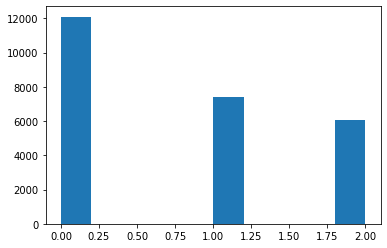

In [ ]:
y = y_test
print(len(y))
plt.hist(y)  

In [ ]:
#df_describe = pd.DataFrame(y_test)
#df_describe.describe(percentiles = [x/100 for x in range(0,100,1)])

#5. Train LightGBM model

In [ ]:
import lightgbm as lgb

load datasets

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

Initialize the model

In [ ]:
params = {
          'task': 'train', 
          'boosting': 'gbdt',
          'objective': 'multiclass',
          'num_leaves': 10,
          'metric': 'multi_logloss',
          'num_class': 3,
          'num_boost_round' : 200
}
model = lgb.train(params, train_set=lgb_train,valid_sets=lgb_test,early_stopping_rounds=10)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.02294
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.990759
[3]	valid_0's multi_logloss: 0.963038
[4]	valid_0's multi_logloss: 0.939279
[5]	valid_0's multi_logloss: 0.918775
[6]	valid_0's multi_logloss: 0.900834
[7]	valid_0's multi_logloss: 0.885847
[8]	valid_0's multi_logloss: 0.872339
[9]	valid_0's multi_logloss: 0.860473
[10]	valid_0's multi_logloss: 0.850421
[11]	valid_0's multi_logloss: 0.841664
[12]	valid_0's multi_logloss: 0.834007
[13]	valid_0's multi_logloss: 0.827217
[14]	valid_0's multi_logloss: 0.821256
[15]	valid_0's multi_logloss: 0.816105
[16]	valid_0's multi_logloss: 0.811492
[17]	valid_0's multi_logloss: 0.807407
[18]	valid_0's multi_logloss: 0.803815
[19]	valid_0's multi_logloss: 0.800516
[20]	valid_0's multi_logloss: 0.797596
[21]	valid_0's multi_logloss: 0.795094
[22]	valid_0's multi_logloss: 0.792863
[23]	valid_0's multi_logloss: 0.790963
[24]	valid_0's multi_logloss: 0.789294
[25]	valid_0

In [ ]:
model.save_model(filepath + "model/output_model/LGB_classification.txt", num_iteration=model.best_iteration)

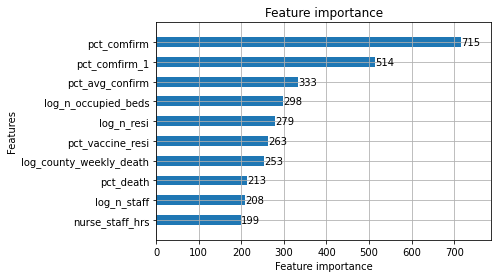

In [ ]:
lgb.plot_importance(model, height=.5,max_num_features=10)

In [ ]:
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
y_pred_probs = model.predict(X_test)

roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class="ovr")

0.8264876341925114

In [ ]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[9566 2247  277]
 [1709 4321 1361]
 [ 820 2570 2690]]
              precision    recall  f1-score   support

           0      0.791     0.791     0.791     12090
           1      0.473     0.585     0.523      7391
           2      0.622     0.442     0.517      6080

    accuracy                          0.649     25561
   macro avg      0.628     0.606     0.610     25561
weighted avg      0.659     0.649     0.648     25561



Reference: multiclass-classification ROC plot

https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

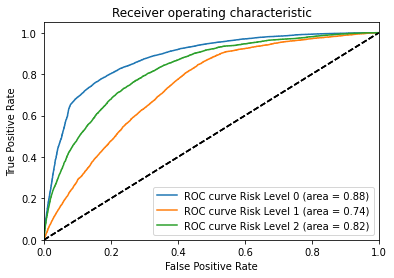

In [ ]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test_dummies = np.array(pd.get_dummies(y_test))
for i in range(0,3):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure()
for i in range(0,3):
    plt.plot(fpr[i], tpr[i], label='ROC curve Risk Level %s (area = %0.2f)' % (i,roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred

array([1, 1, 2, ..., 1, 0, 1])